(305, 1, 1400, 2048)
(200,)
/mnt/sdb/yyamaguchi/airlift/data/experiments/pictures/images/centroid/P20240726-1600_processed_img.png
/mnt/sdb/yyamaguchi/airlift/data/experiments/pictures/signals/centroid/P20240726-1600_processed_pulse.png
(200,)
/mnt/sdb/yyamaguchi/airlift/data/experiments/pictures/images/centroid/P20240726-1606_processed_img.png
/mnt/sdb/yyamaguchi/airlift/data/experiments/pictures/signals/centroid/P20240726-1606_processed_pulse.png
(200,)
/mnt/sdb/yyamaguchi/airlift/data/experiments/pictures/images/centroid/P20240726-1614_processed_img.png
/mnt/sdb/yyamaguchi/airlift/data/experiments/pictures/signals/centroid/P20240726-1614_processed_pulse.png
(200,)
/mnt/sdb/yyamaguchi/airlift/data/experiments/pictures/images/centroid/P20240729-1437_processed_img.png
/mnt/sdb/yyamaguchi/airlift/data/experiments/pictures/signals/centroid/P20240729-1437_processed_pulse.png
(200,)
/mnt/sdb/yyamaguchi/airlift/data/experiments/pictures/images/centroid/P20240729-1351_processed_img.png
/mnt/

KeyboardInterrupt: 

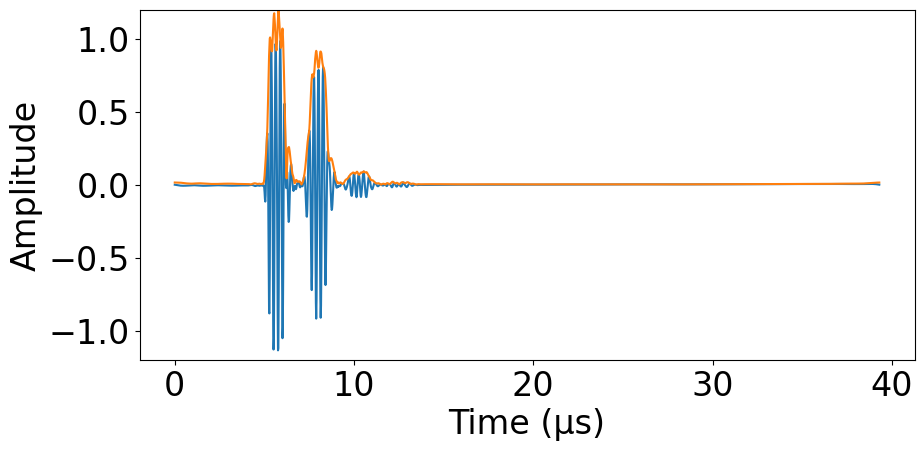

In [ ]:
import numpy as np
from scipy import signal
import pywt
import matplotlib.pyplot as plt
import polars as pl
import os

x_train_path="/mnt/sdb/yyamaguchi/airlift/data/experiments/dropped_data/x_train_single.npy"
t_train_path="/mnt/sdb/yyamaguchi/airlift/data/experiments/dropped_data/t_train_dropped.npy"
info_path="/mnt/sdb/yyamaguchi/airlift/data/experiments/dropped_data/target_valiables.csv"
img_save_path="/mnt/sdb/yyamaguchi/airlift/data/experiments/pictures/images"
pulse_save_path="/mnt/sdb/yyamaguchi/airlift/data/experiments/pictures/signals"
fs=52083333.8426

preprocess_name="centroid"
sos_bp=signal.butter(N=16,Wn=[1e6,10e6],btype="bandpass",
                    output="sos",fs=fs)
sos_bs=signal.butter(N=16,Wn=[2e6,6e6],btype="bandstop",
                     output="sos",fs=fs)
def hpfilter(x, axis=None):
    return x - np.mean(x,axis,keepdims=True)
def maddest(d, axis=None):
    return np.mean(np.abs(d - np.mean(d, axis, keepdims=True)), axis, keepdims=True)
def denoise(x, wavelet='db9', level=1,axis=None):
    x = hpfilter(x,axis=axis)
    coeff = pywt.wavedec(x, wavelet, mode="per",axis=axis)
    sigma = (1/0.6745) * maddest(coeff[-level], axis=axis)

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    return pywt.waverec(coeff, wavelet, mode='per',axis=axis)

img_save_path=os.path.join(img_save_path,preprocess_name)
pulse_save_path=os.path.join(pulse_save_path,preprocess_name)
target_list=np.load(t_train_path)
df = pl.read_csv(info_path, encoding="SHIFT_JIS")
count=0
signal_list=np.load(x_train_path)
signal_list=signal_list[:,:,:,:2048]
print(signal_list.shape)
feature_list=[]
valid_t_list=[]

for i,(x,target) in enumerate(zip(signal_list, target_list)):
    s = df.filter(df["固相見かけ流速"]==target[0],
                  df["気相見かけ流速"]==target[1],
                  df["液相見かけ流速"]==target[2])
    if s.shape[0]!=1:
        if count==0:
            s=s[0]
            count+=1
        else:
            if s.shape[0]>count+1:
                count+=1
            else:
                count=0
            continue
    date=s["日付"].item()
    time=s["時分"].item()
    base_name=f"P{date}-{time}_processed"

    x=x[0,200:400,:]
    # x=signal.sosfiltfilt(sos_bp,x,1)
    x = denoise(x,axis=1)

    wall_idx=np.argmax(x>0.5,axis=1)+200
    start_idx=np.mean(wall_idx).astype(int)

    # x=signal.sosfiltfilt(sos_bs,x,1)

    x_pulse=x[100,:]
    x=np.abs(signal.hilbert(x,axis=1))
    x_amp=x[100,:]

    x=x[:,start_idx:start_idx+1500]
    x_pulse_zoom=x_pulse[start_idx:start_idx+1500]
    x_amp_zoom=x_amp[start_idx:start_idx+1500]
    t=np.arange(1500)/fs
    
    centroid=t*np.power(x,2)*1e6
    centroid=np.sum(centroid,axis=1)
    intensity_sum=np.sum(np.power(x,2),axis=1)
    centroid=centroid/intensity_sum
    print(centroid.shape)
    feature_list.append(centroid)
    valid_t_list.append(target)

    plt.figure(figsize=(15, 10))
    plt.rcParams['font.size'] = 24
    plt.subplot(1,2,1)
    #plt.imshow(img_data, aspect='auto', cmap='viridis', extent=[t[0]*1e6, t[-1]*1e6, img_data.shape[0]-0.5, -0.5],vmin=0,vmax=1)
    plt.imshow(x, aspect='auto', interpolation='nearest',cmap='jet', extent=[t[0]*1e6, t[-1]*1e6, x.shape[0]-0.5, -0.5])
    #plt.imshow(img_data, aspect='auto', cmap='viridis', extent=[t[0], t[-1], img_data.shape[0]-0.5, -0.5])
    plt.colorbar(label='Amplitude')
    plt.title(f'$\\alpha_s={target[3]:.2g},\\alpha_g={target[4]:.2g},\\alpha_l={target[5]:.2g}$')
    plt.xlabel('Time (μs)')
    plt.ylabel('Pulse Number')
    plt.tight_layout()
    plt.subplot(1,2,2)
    plt.plot(centroid,np.arange(200))
    plt.xlabel('Centroid (μs)')
    plt.tick_params(labelleft=False)
    plt.xlim(np.min(t)*1e6,np.max(t)*1e6)
    new_save_path = os.path.join(img_save_path, f"{base_name}_img.png")
    print(new_save_path)
    plt.savefig(new_save_path)
    plt.close()

    plt.figure(figsize=(10, 10))
    plt.rcParams['font.size'] = 24
    plt.subplot(2,1,1)
    t=np.arange(x_pulse.shape[0])/fs
    plt.plot(t*1e6,x_pulse)
    plt.plot(t*1e6,x_amp)
    plt.ylabel('Amplitude')
    plt.xlabel('Time (μs)')
    plt.ylim(-1.2,1.2)
    plt.tight_layout()
    plt.legend(["Pulse","Amplitude"], loc='upper right')
    plt.title(f'$\\alpha_s={target[3]:.2g},\\alpha_g={target[4]:.2g},\\alpha_l={target[5]:.2g}$')
    plt.subplot(2,1,2)
    t=np.arange(x_pulse_zoom.shape[0])/fs
    plt.plot(t*1e6,x_pulse_zoom)
    plt.plot(t*1e6,x_amp_zoom)
    plt.ylabel('Amplitude')
    plt.xlabel('Time (μs)')
    plt.ylim(-0.2,0.2)
    plt.vlines(centroid[100],-0.2,0.2,color="red")
    plt.tight_layout()
    plt.legend(["Pulse","Amplitude"], loc='upper right')
    new_save_path = os.path.join(pulse_save_path, f"{base_name}_pulse.png")
    print(new_save_path)
    plt.savefig(new_save_path)
    plt.close()

In [ ]:
import h5py
import json
import numpy as np
import os

file_path="/mnt/sdb/yyamaguchi/psdata2matlab/simulation/rawsignal/bubblerand2d/data/solid_liquid_reflector_linear1800.mat"

# Load simulation config from JSON
with open("/home/user01/Document/yyamaguchi/documents/kwavesource2d/config.json", 'r') as f:
    config = json.load(f)

# Open the .mat (HDF5) file and inspect structure
#with h5py.File(file_path, 'r') as g:
#    z_group = g['#refs#/z']
#    print(g.keys())  # Print top-level keys for inspection
#    print(list(z_group.keys()))  # Print keys in z group

# Extract simulation parameters from config
end_time = config["simulation"]["t_end"]
cfl = config["simulation"]["CFL"]
sound_speed = config["medium"]["water"]["sound_speed"]
dx = config["grid"]["dx"]
dz = config["grid"]["dz"]
dt = cfl * dx / sound_speed
fs = 1 / dt
print(fs)

# Try to get sensor_data or fallback to z group
with h5py.File(file_path, 'r') as g:
    keys = g.keys()
    print(f"keys:", g.keys())
    if 'sensor_data' in g:
        # If 'sensor_data' exists as a dataset, use it
        sensor_data = g['sensor_data'][:]
        print(sensor_data.shape)
        # processed_data = sensor_data[15]
        # Get all top-level keys in the file
        # keys = list(sensor_data.keys())
        # print(f"keys:", keys)
    else:
        # If 'sensor_data' does not exist, use '#refs#/z' group
        z_group = g['#refs#']
        keys = list(z_group.keys())
        print(f"keys:", keys)
        key_15 = keys[15] if len(keys) > 15 else keys[0]
        print(f"key_15:", key_15)
        processed_data = z_group[key_15][:]
        # Collect all datasets in z_group as a list
        sensor_data = [z_group[k][:] for k in keys]
    keys = list(keys)

# print(keys)
# Reshape processed_data to [1, :, 1] for consistency
# [number of measurements, sensor values, sensor index, (optional) vertical vector]
# Todo: implement scan_line function of kwave
# sensor_data = np.mean(sensor_data,axis=1)
processed_data = sensor_data[np.newaxis, :, 50, np.newaxis]
processed_data_size = processed_data.shape[1]
processed_data=processed_data[:,processed_data_size//2:,:]
processed_data=np.array(processed_data)
#processed_data=np.abs(hilbert(processed_data[:,50001:,:]))
#processed_data=processed_data[::20]
print(processed_data[0, :, 0].shape)  # Confirm the shape of the signal values

# Prepare dictionary for saving
save_dict = {
    "processed_data": processed_data,
    "fs": fs,
    "original_keys": keys,
    # Add other metadata here if needed
}

base_filename = os.path.splitext(os.path.basename(file_path))[0]
save_path = os.path.join(output_dir, f"{base_filename}_processed.npz")
np.savez(save_path, **save_dict)
print(f"Processed data and metadata saved to: {save_path}")
return save_path

In [ ]:
import numpy as np
import os
import glob
import scipy.signal as signal
import matplotlib.pyplot as plt

signal_dir="/mnt/sdb/yyamaguchi/psdata2matlab/experiments/processed/gas_liquid"
save_path="/mnt/sdb/yyamaguchi/airlift/data/experiments/pictures/images"

signal_list=glob.glob("*.npz",root_dir=signal_dir)

for signal_path in signal_list:
    signal_path=os.path.join(signal_dir,signal_path)
    signal_dict=np.load(signal_path)
    fs=signal_dict["fs"]
    print(fs)
    x=signal_dict["processed_data"]
    x=x[5200:5400,:,0]
    sos=signal.butter(N=16,Wn=[1e6,10e6],btype="bandpass",
                    output="sos",fs=fs)
    x=signal.sosfiltfilt(sos,x,1)
    x=np.abs(signal.hilbert(x,axis=1))
    wall_idx=np.argmax(x>0.5,axis=1)+180
    start_idx=np.mean(wall_idx).astype(int)
    x=x[:,start_idx:start_idx+1500]
    t=np.arange(1500)/fs
    print(x.shape)
    plt.figure(figsize=(10, 10))
    plt.rcParams['font.size'] = 20
    #plt.imshow(img_data, aspect='auto', cmap='viridis', extent=[t[0]*1e6, t[-1]*1e6, img_data.shape[0]-0.5, -0.5],vmin=0,vmax=1)
    plt.imshow(x, aspect='auto', interpolation='nearest',cmap='jet', extent=[t[0]*1e6, t[-1]*1e6, x.shape[0]-0.5, -0.5])
    #plt.imshow(img_data, aspect='auto', cmap='viridis', extent=[t[0], t[-1], img_data.shape[0]-0.5, -0.5])
    plt.colorbar(label='Amplitude')
    plt.xlabel('Time (μs)')
    plt.ylabel('Pulse Number')
    plt.tight_layout()
    import os
    base_name = os.path.splitext(os.path.basename(signal_path))[0]
    new_save_path = os.path.join(save_path, f"{base_name}_img.png")
    print(new_save_path)
    plt.savefig(new_save_path)
    plt.close()

52083333.842615336
(200, 1500)
/mnt/sdb/yyamaguchi/airlift/data/experiments/pictures/images/P20240820-1617_processed_img.png
52083333.842615336
(200, 1500)
/mnt/sdb/yyamaguchi/airlift/data/experiments/pictures/images/P20240820-1622_processed_img.png
52083333.842615336
(200, 1500)
/mnt/sdb/yyamaguchi/airlift/data/experiments/pictures/images/P20240820-1532_processed_img.png
52083333.842615336
(200, 1500)
/mnt/sdb/yyamaguchi/airlift/data/experiments/pictures/images/P20240919-1341_processed_img.png
52083333.842615336
(200, 1500)
/mnt/sdb/yyamaguchi/airlift/data/experiments/pictures/images/P20240820-1539_processed_img.png
52083333.842615336
(200, 1500)
/mnt/sdb/yyamaguchi/airlift/data/experiments/pictures/images/P20240820-1545_processed_img.png
52083333.842615336
(200, 1500)
/mnt/sdb/yyamaguchi/airlift/data/experiments/pictures/images/P20240919-1347_processed_img.png
52083333.842615336
(200, 1500)
/mnt/sdb/yyamaguchi/airlift/data/experiments/pictures/images/P20240820-1611_processed_img.png


In [2]:
import numpy as np
import os
import glob
import scipy.signal as signal
import matplotlib.pyplot as plt

raw_path="/mnt/sdb/yyamaguchi/airlift/data/experiments/dropped_data/x_train_dropped.npy"
t_path="/mnt/sdb/yyamaguchi/airlift/data/experiments/dropped_data/t_train_dropped.npy"
save_path="/mnt/sdb/yyamaguchi/airlift/data/experiments/dropped_data/x_train_short.npy"
pic_path="/mnt/sdb/yyamaguchi/airlift/data/experiments/pictures/images"

fs = 52083333.842615336
x=np.load(raw_path)
target=np.load(t_path)

sos = signal.butter(N=16, Wn=[1e6, 10e6], btype="bandpass",
                    output="sos", fs=fs)
x = signal.sosfiltfilt(sos=sos, x=x, axis=3)
print("Filtering raw signal done.")
del sos
for i in range(x.shape[1]):
    x[:,i,:,:] = np.abs(signal.hilbert(x[:,i,:,:], axis=2))
print("Hilbert done.")
max_values_per_col = np.max(x[:,:,:,250:350], axis=3, keepdims=True)
x = x/max_values_per_col
del max_values_per_col
x = np.log1p(x)
t=np.arange(1500)/fs
for x in range(x.shape[0]):
    wall_idx=np.argmax(x>0.5,axis=3)
    start_idx=np.mean(wall_idx).astype(int)+180
    x=x[:,start_idx:start_idx+1500]
for i in range(x.shape[0]):
    x_plot=x[i,0,:,:]
    plt.figure(figsize=(10, 10))
    plt.rcParams['font.size'] = 20
    #plt.imshow(img_data, aspect='auto', cmap='viridis', extent=[t[0]*1e6, t[-1]*1e6, img_data.shape[0]-0.5, -0.5],vmin=0,vmax=1)
    plt.imshow(x_plot, aspect='auto', interpolation='nearest',cmap='jet', extent=[t[0]*1e6, t[-1]*1e6, x.shape[0]-0.5, -0.5])
    #plt.imshow(img_data, aspect='auto', cmap='viridis', extent=[t[0], t[-1], img_data.shape[0]-0.5, -0.5])
    plt.colorbar(label='Amplitude')
    plt.xlabel('Time (μs)')
    plt.ylabel('Pulse Number')
    plt.tight_layout()
    import os
    base_name = target[i,3:6]
    new_save_path = os.path.join(pic_path, f"{base_name[0]}_{base_name[1]}_{base_name[2]}_img.png")
    print(new_save_path)
    plt.savefig(new_save_path)
    plt.close()

np.save(save_path,x)

KeyboardInterrupt: 

In [5]:
from src import mat2npz_sim,npz2png
import os
import glob

# Define input and output directories
# Define the case name as a variable for clarity and reusability
case_name = "solidliquid"
case_dirs= ["bubble_tutorial","bubble2.5","bubble4-5","bubbleCFL0.04",
            "bubbleCFL0.05","bubblerand1","bubblerand2",
            "bubblerandCFL0.03"]
# case_dirs=["case22_mtbr"]
case_dirs = ["bubblerand2d"]

# Define base data directory for clarity
base_data_dir = "/mnt/sdb/yyamaguchi/psdata2matlab/simulation"
visualize_dir = "/mnt/sdb/yyamaguchi/psdata2matlab/visualize"
def convert_all_simulation_mat_to_npz(case_name, base_data_dir):
    """
    Convert all simulation .mat files in the specified case directory to .npz format.

    Parameters
    ----------
    case_name : str
        The name of the simulation case (e.g., "case5").
    base_data_dir : str
        The base directory where simulation data is stored.
    """
    # Define input directory for raw simulation signals (relative to base_data_dir and case_name)
    mat_dir = os.path.join(base_data_dir, f"rawsignal/{case_name}/data")

    # Define config file path (relative to base_data_dir and case_name)
    config_path = os.path.join(base_data_dir, f"rawsignal/{case_name}/config.json")

    # Define output directory for processed files (relative to base_data_dir and case_name)
    output_dir = os.path.join(base_data_dir, f"processed/{case_name}")
    # Create the output directory if it does not exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created output directory: {output_dir}")
    # Save a copy of the config.json file to the output directory for reference
    import shutil
    config_copy_path = os.path.join(output_dir, "config.json")
    shutil.copy2(config_path, config_copy_path)
    print(f"Copied config.json to: {config_copy_path}")

    # Create the output directory if it does not exist
    os.makedirs(output_dir, exist_ok=True)
    mat_files_list = glob.glob(os.path.join(mat_dir, "*.mat"))
    for mat_file in mat_files_list:
        print(f"Processing: {mat_file}")
        mat2npz_sim(mat_file, config_path, output_dir)

# 関数の呼び出し例
for case_name in case_dirs:
    import h5py
    mat_dir = os.path.join(base_data_dir, f"rawsignal/{case_name}/data")
    mat_files_list = glob.glob(os.path.join(mat_dir, "*.mat"))
    for mat_file in mat_files_list:

        file_path = mat_file

        # アクセスしたいキーのリスト
        keys_to_access = ['#refs#', '#subsystem#', 'kgrid', 'sensor_data']

        with h5py.File(file_path, 'r') as f:
            
            print("--- 指定されたキーへのアクセス結果 ---")
            
            for key in keys_to_access:
                if key in f:
                    # キーに対応するHDF5オブジェクトを取得
                    obj = f[key]
                    
                    # オブジェクトの型をチェック
                    if isinstance(obj, h5py.Dataset):
                        # データセットの場合
                        print(f"🔑 {key}: ✅ データセット (形状: {obj.shape}, 型: {obj.dtype})")
                        
                    elif isinstance(obj, h5py.Group):
                        # グループの場合
                        print(f"🔑 {key}: 📁 グループ (内部キー数: {len(obj.keys())})")
                    
                    else:
                        # その他のHDF5オブジェクトの場合
                        print(f"🔑 {key}: ❓ その他のHDF5オブジェクト ({type(obj)})")
                
                else:
                    print(f"🔑 {key}: ❌ ファイル内に見つかりません。")
    convert_all_simulation_mat_to_npz(case_name, base_data_dir)

#npz2png(file_path="/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/bubble2.5/solid_liquid_reflector1_processed.npz",save_path=visualize_dir,full=False,pulse_index=0)
# npz2png(file_path="/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/bubbleCFL0.05/solid_liquid_reflector1_processed.npz",save_path=visualize_dir,full=False,pulse_index=0)

--- 指定されたキーへのアクセス結果 ---
🔑 #refs#: 📁 グループ (内部キー数: 22)
🔑 #subsystem#: 📁 グループ (内部キー数: 1)
🔑 kgrid: ✅ データセット (形状: (1, 6), 型: uint32)
🔑 sensor_data: 📁 グループ (内部キー数: 1)
--- 指定されたキーへのアクセス結果 ---
🔑 #refs#: 📁 グループ (内部キー数: 22)
🔑 #subsystem#: 📁 グループ (内部キー数: 1)
🔑 kgrid: ✅ データセット (形状: (1, 6), 型: uint32)
🔑 sensor_data: 📁 グループ (内部キー数: 1)
--- 指定されたキーへのアクセス結果 ---
🔑 #refs#: 📁 グループ (内部キー数: 22)
🔑 #subsystem#: 📁 グループ (内部キー数: 1)
🔑 kgrid: ✅ データセット (形状: (1, 6), 型: uint32)
🔑 sensor_data: 📁 グループ (内部キー数: 1)
--- 指定されたキーへのアクセス結果 ---
🔑 #refs#: 📁 グループ (内部キー数: 22)
🔑 #subsystem#: 📁 グループ (内部キー数: 1)
🔑 kgrid: ✅ データセット (形状: (1, 6), 型: uint32)
🔑 sensor_data: 📁 グループ (内部キー数: 1)
Copied config.json to: /mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/bubblerand2d/config.json
Processing: /mnt/sdb/yyamaguchi/psdata2matlab/simulation/rawsignal/bubblerand2d/data/solid_liquid_reflector1800.mat
714285714.2857143
keys: <KeysViewHDF5 ['#refs#', '#subsystem#', 'kgrid', 'sensor_data']>


TypeError: Accessing a group is done with bytes or str, not <class 'slice'>

In [1]:
from src import calculate_gvf_and_signal,npz2png,process_case_and_return_dataset, process_case_and_png
import numpy as np
import math
import json
import glob
import os
#units are all mm


# Define the base directory containing all cases
processed_base_dir = "/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed"
output_path = "/mnt/sdb/yyamaguchi/psdata2matlab/simulation/dataset"
csv_base_dir ="/mnt/sdb/yyamaguchi/psdata2matlab/simulation/rawsignal"

# Get all case directories (e.g., case5, case6, ...)
case_dirs = sorted([d for d in os.listdir(csv_base_dir) if os.path.isdir(os.path.join(processed_base_dir, d)) and d.startswith("case")])
print(case_dirs)

# case_dirs= ["bubble_tutorial","bubble2.5","bubble4-5","bubbleCFL0.04",
#             "bubbleCFL0.05","bubblerand1","bubblerand2",
#             "bubblerandCFL0.03","bubblerand2d"]
case_dirs=["solidliquid"]
x_train_list = []
t_train_list = []

for case_name in case_dirs:
    if case_name != "case4" and case_name!="case5":
        base_dir = os.path.join(processed_base_dir, case_name)
        csv_dir = os.path.join(csv_base_dir, case_name)
        print(f"Processing {case_name} in {base_dir}")
        x_tmp = process_case_and_png(case_name, base_dir,
                                    csv_dir, 
                                    rolling_window=True,
                                    window_size=30, window_stride=10,
                                    log1p=True,
                                    if_hilbert=True,
                                    png_name='erode')

['case0', 'case10', 'case12', 'case14', 'case16', 'case18', 'case2', 'case20', 'case22', 'case22_mtbr', 'case22_new', 'case3', 'case4', 'case6', 'case8']
Processing solidliquid in /mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/solidliquid
['/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/solidliquid/solid_liquid_reflector1_processed.npz']
csv_path:/mnt/sdb/yyamaguchi/psdata2matlab/simulation/rawsignal/solidliquid/location_seed/location1.csv
npz_path:/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/solidliquid/solid_liquid_reflector1_processed.npz
fs: 999999999.9999999
input tmp shape(2500,)
input_tmp max: 839
/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/solidliquid/solidliquid_erode1.png
/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/solidliquid/solidliquid_raw1.png
Xf: 579361.1875
/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/solidliquid/solidliquid_raw1_fft.png


In [14]:
import numpy as np

t = np.arange(0,1,1/16)
s0 = np.zeros((64,1))
s0[0:16,0]= t**2
s0[16:32,0]= 0.2
s0[32:48,0]=(1-t)**2 -0.5

p=np.array([0.482963,0.836516,0.224144,-0.12941])

sup=len(p)
q = -np.array([-1,1,-1,1])*np.flip(p)

def fwt1d(s0,p,q):
    s0 = s0[:,0]
    s_len = len(s0)
    s1 = np.zeros((s_len/2,1))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import scipy
from scipy.fftpack import fft

# npz_file1 = "/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/bubblerandCFL0.03/solid_liquid_reflector2_processed.npz"
# npz_file2 = "/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/bubblerand2/solid_liquid_reflector2_processed.npz"

# npz_dict1 = np.load(npz_file1)
# npz_dict2 = np.load(npz_file2)
# base_dir = "/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/bubblerandCFL0.03"

# raw_tmp1 = npz_dict1["processed_data"][0,:,0]
# fs1 = npz_dict1["fs"]
# t=np.arange(0e-6,50e-6,50e-6/len(raw_tmp1))
# len_plt= np.min([len(t), len(raw_tmp1)])
# plt.figure(figsize=(10, 4))
# plt.rcParams["font.size"] = 18
# plt.plot(t[:len_plt]*1e6, raw_tmp1[:len_plt]*1e-3, alpha=0.5, color='blue', label='CFL=0.03')
# plt.legend()
# raw_tmp1 = npz_dict2["processed_data"][0,:,0]
# fs1 = npz_dict1["fs"]
# t=np.arange(0e-6,50e-6,50e-6/len(raw_tmp1))
# len_plt= np.min([len(t), len(raw_tmp1)])
# plt.plot(t[:len_plt]*1e6, raw_tmp1[:len_plt]*1e-3, alpha=0.5, color='red', label='CFL=0.05')
# plt.legend()
# plt.xlim(5,20)
# plt.ylim(-5, 5)
# plt.xlabel('Time (μs)')
# plt.ylabel('Amplitude (kPa)')
# plt.tight_layout()
# import os
# #base_name = os.path.splitext(os.path.basename(file_path))[0]
# #save_path = os.path.join(base_dir, 'graph')
# new_save_path = os.path.join(base_dir, f"bubbleCFL.png")
# print(new_save_path)
# plt.savefig(new_save_path)
# plt.close()

npz_file3 = "/mnt/sdb/yyamaguchi/psdata2matlab/experiments/processed/solid_liquid/P20241007-1616_processed.npz"

npz_dict = np.load(npz_file3)
raw_tmp = npz_dict["processed_data"][5000,208:2708,0]
fs = npz_dict["fs"]
base_dir = "/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/bubblerandCFL0.03"
t=np.arange(0e-6,50e-6,50e-6/len(raw_tmp))
len_plt= np.min([len(t), len(raw_tmp)])
plt.figure(figsize=(10, 4))
plt.rcParams["font.size"] = 18
raw_tmp2 = raw_tmp.copy()
import scipy.signal as signal
sos = signal.butter(N=4, Wn=[1e6,10e6], btype="bandpass",output="sos",fs=fs)
raw_tmp2 = signal.sosfiltfilt(sos,raw_tmp2)

plt.plot(t[:len_plt]*1e6, raw_tmp2[:len_plt], color='blue', label='Raw Signal')
plt.legend()
# plt.xlim(10,20)
# plt.ylim(-0.2, 0.2)
plt.xlabel('Time (μs)')
plt.ylabel('Amplitude (V)')
plt.tight_layout()
import os
#base_name = os.path.splitext(os.path.basename(file_path))[0]
#save_path = os.path.join(base_dir, 'graph')
new_save_path = os.path.join(base_dir, f"P20240827-1552-bandpass.png")
print(new_save_path)
plt.savefig(new_save_path)
plt.close()

plt.figure(figsize=(10, 4))
plt.rcParams["font.size"] = 18
plt.plot(t[:len_plt]*1e6, raw_tmp[:len_plt], color='blue', label='Raw Signal')
plt.legend()
# plt.xlim(10,20)
# plt.ylim(-0.2, 0.2)
plt.xlabel('Time (μs)')
plt.ylabel('Amplitude (V)')
plt.tight_layout()
import os
#base_name = os.path.splitext(os.path.basename(file_path))[0]
#save_path = os.path.join(base_dir, 'graph')
new_save_path = os.path.join(base_dir, f"P20240827-1552-raw.png")
print(new_save_path)
plt.savefig(new_save_path)
plt.close()

Xf = fft(raw_tmp)
Xf = np.abs(Xf)
Xf = Xf[:len(raw_tmp)//2]
Xf = Xf/len(Xf)
freq = np.arange(0,25e6,1/50e-6)
plt.figure(figsize=(10, 4))
plt.rcParams["font.size"] = 18
plt.plot(freq*1e-6, Xf[0:len(freq)], color='blue', label='FFT')
plt.legend()
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude')
plt.ylim(0,0.04)
plt.tight_layout()
import os
#base_name = os.path.splitext(os.path.basename(file_path))[0]
#save_path = os.path.join(base_dir, 'graph')
new_save_path = os.path.join(base_dir, f"P20240827-1552-fft.png")
print(new_save_path)
plt.savefig(new_save_path)
plt.close()

/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/bubblerandCFL0.03/P20240827-1552-bandpass.png
/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/bubblerandCFL0.03/P20240827-1552-raw.png
/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/bubblerandCFL0.03/P20240827-1552-fft.png


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import scipy
from scipy.fftpack import fft

npz_file3 = "/mnt/sdb/yyamaguchi/psdata2matlab/experiments/processed/gas_liquid/P20240919-1341_processed.npz"

npz_dict = np.load(npz_file3)
raw_tmp = npz_dict["processed_data"][5000,208:2708,0]
fs = npz_dict["fs"]
base_dir = "/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/bubblerandCFL0.03"
t=np.arange(0e-6,50e-6,50e-6/len(raw_tmp))


raw_tmp_wt = raw_tmp.copy()
raw_tmp_wt = raw_tmp_wt - np.mean(raw_tmp_wt)
# p=np.array([0.482963,0.836516,0.224144,-0.12941])

# sup=len(p)
# q = -np.array([-1,1,-1,1])*np.flip(p)

# def fwt1d(s, p, q):
#     s_len = len(s)
#     s1 = np.zeros(int(s_len/2))
#     w1 = np.copy(s1)

#     k=np.arange(0,s_len,2)
#     filt_len = len(p)
#     for n in range(filt_len):
#         index = (n+k-1)%s_len
#         s1 += p[n]*s[index]
#         w1 += q[n]*s[index]
#     return s1,w1

# def ifwt1d(s1, w1,p, q):
#     s_len = len(s1)
#     s0 = np.zeros(2*s_len)
#     n = np.arange(s_len)
#     n2 = 2*n.copy()+1
#     n1 = 2*n.copy()
#     f_len = len(p)
#     ofs = np.max([2048, s_len])
#     for k in range(int(f_len/2)):
#         index = (n-k+ofs)%s_len
#         s0[n2] += p[2*k+1]*s1[index]+q[2*k+1]*w1[index]
#         s0[n1] += p[2*k]*s1[index]+q[2*k]*w1[index]
#     return s0
    

# n = len(raw_tmp_wt)
# L = int(np.floor(np.log2(n)))
# J = int(L)
# coeff = np.zeros(n)
# sk = np.copy(raw_tmp_wt)

# for j in range(J):
#     sk, wk = fwt1d(sk,p,q)
#     coeff[2**(L-j-1):2**(L-j)] = wk
#     coeff[:2**(L-j-1)] = sk
# threshold = np.sqrt(2*np.log(n))* 0.00000001
# coeff = np.where(np.abs(coeff)>=threshold,coeff,0)

# sk = coeff[:2**(L-J)]
# for j_minus in range (J):
#     j = J-j_minus-1
#     wk = coeff[2**(L-j-1):2**(L-j)]
#     sk = ifwt1d(sk,wk,p,q)

import pywt

def maddest(d, axis=None):
    return np.mean(np.abs(d - np.mean(d, axis)), axis)
def denoise(x, wavelet='db9', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    return pywt.waverec(coeff, wavelet, mode='per')
sk = denoise(raw_tmp_wt)

len_plt= np.min([len(t), len(sk)])
plt.figure(figsize=(10, 4))
plt.rcParams["font.size"] = 18
plt.plot(t[:len_plt]*1e6, sk[:len_plt], color='blue', label='Raw Signal')
plt.legend()
# plt.xlim(10,20)
# plt.ylim(-0.2, 0.2)
plt.xlabel('Time (μs)')
plt.ylabel('Amplitude (V)')
plt.tight_layout()
import os
#base_name = os.path.splitext(os.path.basename(file_path))[0]
#save_path = os.path.join(base_dir, 'graph')
new_save_path = os.path.join(base_dir, f"P20240827-1552-wavelet.png")
print(new_save_path)
plt.savefig(new_save_path)
plt.close()

len_plt= np.min([len(t), len(raw_tmp)])
plt.figure(figsize=(10, 4))
plt.rcParams["font.size"] = 18
raw_tmp2 = raw_tmp.copy()
import scipy.signal as signal
sos = signal.butter(N=4, Wn=[1e6,10e6], btype="bandpass",output="sos",fs=fs)
raw_tmp2 = signal.sosfiltfilt(sos,raw_tmp2)

plt.plot(t[:len_plt]*1e6, raw_tmp2[:len_plt], color='blue', label='Raw Signal')
plt.legend()
# plt.xlim(10,20)
# plt.ylim(-0.2, 0.2)
plt.xlabel('Time (μs)')
plt.ylabel('Amplitude (V)')
plt.tight_layout()
import os
#base_name = os.path.splitext(os.path.basename(file_path))[0]
#save_path = os.path.join(base_dir, 'graph')
new_save_path = os.path.join(base_dir, f"P20240827-1552-bandpass.png")
print(new_save_path)
plt.savefig(new_save_path)
plt.close()

Xf = fft(sk)
Xf = np.abs(Xf)
Xf = Xf[:len(sk)//2]
Xf = Xf/len(Xf)
freq = np.arange(0,25e6,1/50e-6)
plt.figure(figsize=(10, 4))
plt.rcParams["font.size"] = 18
plt.plot(freq*1e-6, Xf[0:len(freq)], color='blue', label='FFT')
plt.legend()
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude')
plt.ylim(0,0.04)
plt.tight_layout()
import os
#base_name = os.path.splitext(os.path.basename(file_path))[0]
#save_path = os.path.join(base_dir, 'graph')
new_save_path = os.path.join(base_dir, f"P20240827-1552-fft-wt.png")
print(new_save_path)
plt.savefig(new_save_path)
plt.close()

t=np.arange(0e-6,50e-6,50e-6/len(raw_tmp_wt))
len_plt= np.min([len(t), len(raw_tmp_wt)])
plt.figure(figsize=(10, 4))
plt.rcParams["font.size"] = 18
raw_tmp2 = raw_tmp_wt.copy()
import scipy.signal as signal
sos = signal.butter(N=4, Wn=[1e6,10e6], btype="bandpass",output="sos",fs=fs)
raw_tmp2 = signal.sosfiltfilt(sos,raw_tmp2)

plt.plot(t[:len_plt]*1e6, raw_tmp2[:len_plt], color='blue', label='Raw Signal')
plt.legend()
# plt.xlim(10,20)
# plt.ylim(-0.2, 0.2)
plt.xlabel('Time (μs)')
plt.ylabel('Amplitude (V)')
plt.tight_layout()
import os
#base_name = os.path.splitext(os.path.basename(file_path))[0]
#save_path = os.path.join(base_dir, 'graph')
new_save_path = os.path.join(base_dir, f"P20240827-1552-bandpass.png")
print(new_save_path)
plt.savefig(new_save_path)
plt.close()

Xf = fft(raw_tmp2)
Xf = np.abs(Xf)
Xf = Xf[:len(raw_tmp2)//2]
Xf = Xf/len(Xf)
freq = np.arange(0,25e6,1/50e-6)
plt.figure(figsize=(10, 4))
plt.rcParams["font.size"] = 18
plt.plot(freq*1e-6, Xf[0:len(freq)], color='blue', label='FFT')
plt.legend()
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude')
plt.ylim(0,0.04)
plt.tight_layout()
import os
#base_name = os.path.splitext(os.path.basename(file_path))[0]
#save_path = os.path.join(base_dir, 'graph')
new_save_path = os.path.join(base_dir, f"P20240827-1552-fft-bp.png")
print(new_save_path)
plt.savefig(new_save_path)
plt.close()

/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/bubblerandCFL0.03/P20240827-1552-wavelet.png
/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/bubblerandCFL0.03/P20240827-1552-bandpass.png
/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/bubblerandCFL0.03/P20240827-1552-fft-wt.png
/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/bubblerandCFL0.03/P20240827-1552-bandpass.png
/mnt/sdb/yyamaguchi/psdata2matlab/simulation/processed/bubblerandCFL0.03/P20240827-1552-fft-bp.png
